# Machine Learning Foundation

## Course 6, Part g: Time Series Deep Learning DEMO

# Introduction

In previous lessons, we've gone from learning the basic components of time series to employing advanced signal transformation techniques. As the culmination of these lessons, we'll now turn toward deep learning as a method for time series forecasting. We'll see how **recurrent neural networks** can automatically learn how to model series components like seasonality and autocorrelation without special preprocessing. In the process, we'll gain exposure to the python library **Keras**, which provides an excellent interface for constructing neural networks. 

# Learning Outcomes
You should walk away from this Python tutorial with:
1. A practical understanding of how to build and train a simple RNN or LSTM for time series forecasting, using keras.
2. Introductory experience in tuning RNN/LSTM parameters.

# Imports

In [3]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
os.chdir('data')
from colorsetup import colors, palette
plt.style.use('fivethirtyeight')
sns.set_palette(palette)
import pandas as pd
from datetime import datetime
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Section 1: Simple RNN

In this section, we will build a recurrent neural network and train it to forecast a single time series. We'll use a dataset provided by the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities) that measures hourly air quality in Chinese cities/city districts<sup>1</sup>.

1. Liang, X., S. Li, S. Zhang, H. Huang, and S. X. Chen (2016), PM2.5 data reliability, consistency, and air quality assessment in five Chinese cities, J. Geophys. Res. Atmos., 121, 10220â€“10236

#### Setting Up The Data

We'll start by working with Beijing data, and filter the dataset down to records from 2015. 

In [4]:
df_Beijing = pd.read_csv('./FiveCitiesPM/Beijing.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


We are interested in attempting to forecast the 'PM' series, which are measurements of air pollution for several different districts.  Note that there are occasional missing values in these series, which we can fill with simple linear interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values. 

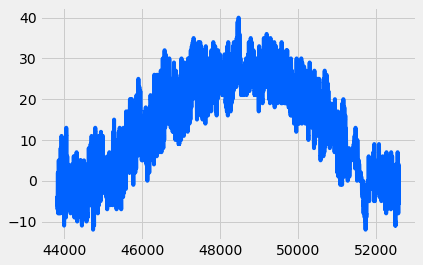

In [5]:
plt.plot(df_Beijing['TEMP'])

In [6]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['TEMP'] = df_Beijing['TEMP'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

In [7]:
def make_date(row):
    return datetime(year = row['year'], month = row['month'], day = row['day'], hour = row['hour'])
df_Beijing['date'] = df_Beijing.apply(make_date,axis=1)
df_Beijing.set_index(df_Beijing.date,inplace=True)

<AxesSubplot:xlabel='date'>

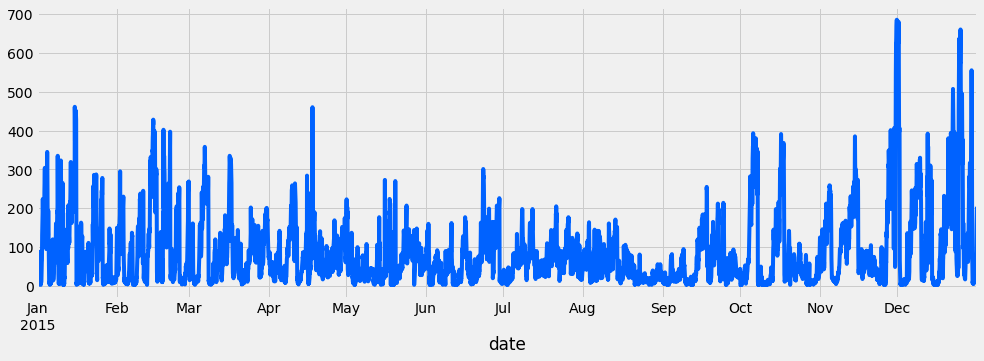

In [8]:
#quick plot of full time series
plt.figure(figsize = (15,5))
df_Beijing['PM_Dongsi'].plot()

In [9]:
df_Beijing['PM_Dongsi']

date
2015-01-01 00:00:00      5.0
2015-01-01 01:00:00      4.0
2015-01-01 02:00:00      3.0
2015-01-01 03:00:00      4.0
2015-01-01 04:00:00      3.0
                       ...  
2015-12-31 19:00:00    140.0
2015-12-31 20:00:00    157.0
2015-12-31 21:00:00    171.0
2015-12-31 22:00:00    204.0
2015-12-31 23:00:00    204.0
Name: PM_Dongsi, Length: 8760, dtype: float64

As usual, it's a good idea for us to generate a run-sequence plot before modeling the data. This way we can get a feel for what we're working with. We'll go ahead and define two utility functions that let us extract and plot the last $n$ days of data (remember that this is an hourly time series, so each day has 24 time steps).   

In [10]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """
    
    return df[series_name][-(24*n_days):] 

def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series 
    """
    plt.figure(figsize = (10,5))   
    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

What do the last 6 weeks of data look like?

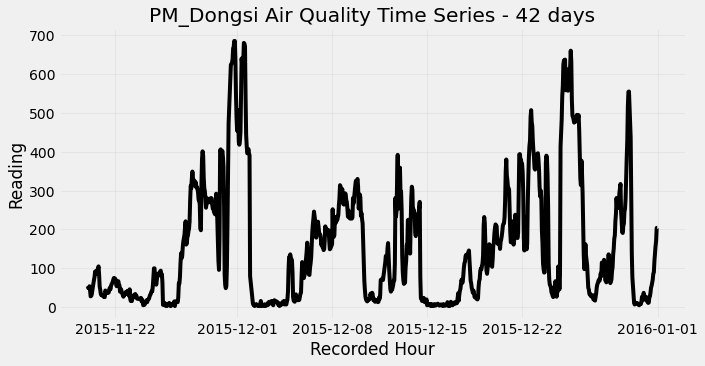

In [11]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

**Review Question**: what components that you've learned in previous lessons appear to be present in this time series? 

**Answer**: There appears to be a periodic component as well as autocorrelation structure.

#### Example 1: Train a simple RNN to forecast the PM_Dongsi time series

Before we can train a neural network with keras, we need to process the data into a format that the library accepts. In particular, for keras RNNs and LSTMs, training samples should be stored in a 3D numpy array of shape **(n_samples, time_steps, n_features)**. Since we'll be using only the series' history to predict its future, we'll only have 1 feature. Also, for the next-step prediction that we'll do in this notebook, target values can be stored in a simple list.

To this end, we define utility functions that allow us to extract the formatted data. The **get_train_test_data** function gives us the flexibility to define the length of the extracted training and test sequences and the number of time steps to use for prediction -- we'll run simple tests of our models by holding out the end of the extracted sequence and generating predictions to compare against the ground truth.

Since our model will perform better with multiple training samples, we draw many slices from the entire training sequence, starting at different points in time. The gap between starting points of these slices is controlled by the **sample_gap** parameter.

In [12]:
df_Beijing.shape

(8760, 19)

In [13]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape 
    [n_samples, time_steps, features]
    """
    
    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)

def get_train_test_data(df, series_name, series_days, input_hours, 
                        test_hours, sample_gap=3):
    """
    Utility processing function that splits an hourly time series into 
    train and test with keras-friendly format, according to user-specified
    choice of shape.    
    
    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network 
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5
    
    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y     
    """
    
    forecast_series = get_n_last_days(df, series_name, series_days).values # reducing our forecast series to last n days

    train = forecast_series[:-test_hours] # training data is remaining days until amount of test_hours
    test = forecast_series[-test_hours:] # test data is the remaining test_hours

    train_X, train_y = [], []

    # range 0 through # of train samples - input_hours by sample_gap. 
    # This is to create many samples with corresponding
    for i in range(0, train.shape[0]-input_hours, sample_gap): 
        train_X.append(train[i:i+input_hours]) # each training sample is of length input hours
        train_y.append(train[i+input_hours]) # each y is just the next step after training sample

    train_X = get_keras_format_series(train_X) # format our new training set to keras format
    train_y = np.array(train_y) # make sure y is an array to work properly with keras
    
    # The set that we had held out for testing (must be same length as original train input)
    test_X_init = test[:input_hours] 
    test_y = test[input_hours:] # test_y is remaining values from test set
    
    return train_X, test_X_init, train_y, test_y

With the **get_train_test_data** utility function in hand, we're all set to extract keras-friendly arrays and start training simple RNN models. We run this function in the cell below. We use the last 56 days of the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next time step. We use the last day of data for visually testing the model.    

In [16]:
df_Beijing.shape

(8760, 19)

In [20]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))

In [21]:
train_y.shape

(436,)

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each. 

In [22]:
print('Training input shape: {}'.format(train_X.shape))
print('Training output shape: {}'.format(train_y.shape))
print('Test input shape: {}'.format(test_X_init.shape))
print('Test output shape: {}'.format(test_y.shape))

Training input shape: (436, 12, 1)
Training output shape: (436,)
Test input shape: (12,)
Test output shape: (12,)


And now we're ready to train! Since we'd like to repeatedly adjust our model's hyperparameters to see what works best, we'll write a reusable function for training a simple RNN model using keras. Take some time to understand what the keras syntax accomplishes at each step and how it relates to what we've learned about RNNs so far.  

In [25]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells  
    epochs (int): number of training epochs   
    """

    # initialize model
    model = Sequential() 
    
    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

Great, now let's use this function to fit a very simple baseline model.

In [24]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

Not bad so far. But we need to work a bit harder to actually extract multi-step predictions from this model, as it was trained to predict only one future time step. For multi-step forecasting, we'll iteratively generate one prediction, append it to the end of the input sequence (and shift that sequence forward by one step), then feed the new sequence back to the model. We stop once we've generated all the time step predictions we need. 

This prediction method and a utility function for plotting its output against the ground truth are defined below. Take some time time to familiarize yourself with the prediction method.    

In [26]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series      
    """
    
    X_init = X_init.copy().reshape(1,-1,1)
    preds = []
    
    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:] # replace first 11 values with 2nd through 12th
        X_init[:,-1,:] = pred # replace 12th value with prediction
    
    preds = np.array(preds).reshape(-1,1)
    
    return preds

def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps 
    
    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title   
    """
    
    y_preds = predict(test_X_init, n_steps=len(y), model=model) # predict through length of y
    # Below ranges are to set x-axes
    start_range = range(1, test_X_init.shape[0]+1) #starting at one through to length of test_X_init to plot X_init
    predict_range = range(test_X_init.shape[0], test_hours)  #predict range is going to be from end of X_init to length of test_hours
    
    #using our ranges we plot X_init
    plt.plot(start_range, test_X_init)
    #and test and actual preds
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')
    
    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])

Ok, we've finally arrived at the time to see how our baseline model does. We can simply run the **predict_and_plot** function on the extracted test data as below, and inspect the resulting plot. 

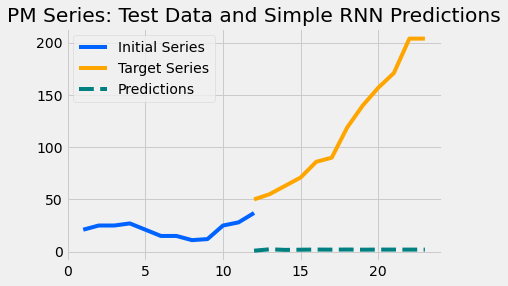

In [27]:
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

It looks like our model is badly underfit and essentially just making constant predictions. That's ok, it was a very simple baseline and trained very quickly. 

We can improve by making the model more expressive, **increasing cell_units**. We can also pass over the training data many more times, **increasing epochs**, giving the model more opportunity to learn the patterns in the data. We'll try that below, it takes a longer time now since our training is more extensive.

Note that there is a significant amount of randomness in neural network training - we may need to retrain the model a few times in order to get
results that we're happy with.

Epoch 1/600
7/7 [==============================] - 1s 5ms/step - loss: 43023.8398
Epoch 2/600
7/7 [==============================] - 0s 3ms/step - loss: 42921.1289
Epoch 3/600
7/7 [==============================] - 0s 3ms/step - loss: 42842.1758
Epoch 4/600
7/7 [==============================] - 0s 3ms/step - loss: 42737.8789
Epoch 5/600
7/7 [==============================] - 0s 3ms/step - loss: 42599.2734
Epoch 6/600
7/7 [==============================] - 0s 3ms/step - loss: 42433.3906
Epoch 7/600
7/7 [==============================] - 0s 3ms/step - loss: 42282.5859
Epoch 8/600
7/7 [==============================] - 0s 3ms/step - loss: 42178.3984
Epoch 9/600
7/7 [==============================] - 0s 3ms/step - loss: 41957.7305
Epoch 10/600
7/7 [==============================] - 0s 3ms/step - loss: 41773.2734
Epoch 11/600
7/7 [==============================] - 0s 4ms/step - loss: 41676.9766
Epoch 12/600
7/7 [==============================] - 0s 3ms/step - loss: 41611.2578
Epoch 13/600


7/7 [==============================] - 0s 3ms/step - loss: 36295.9844
Epoch 100/600
7/7 [==============================] - 0s 3ms/step - loss: 36244.3320
Epoch 101/600
7/7 [==============================] - 0s 3ms/step - loss: 36193.0898
Epoch 102/600
7/7 [==============================] - 0s 3ms/step - loss: 36143.0156
Epoch 103/600
7/7 [==============================] - 0s 3ms/step - loss: 36092.6172
Epoch 104/600
7/7 [==============================] - 0s 3ms/step - loss: 36040.7227
Epoch 105/600
7/7 [==============================] - 0s 3ms/step - loss: 35989.9531
Epoch 106/600
7/7 [==============================] - 0s 3ms/step - loss: 35940.9688
Epoch 107/600
7/7 [==============================] - 0s 3ms/step - loss: 35891.0156
Epoch 108/600
7/7 [==============================] - 0s 3ms/step - loss: 35839.1289
Epoch 109/600
7/7 [==============================] - 0s 3ms/step - loss: 35790.5625
Epoch 110/600
7/7 [==============================] - 0s 3ms/step - loss: 35739.6914
Epoch 

7/7 [==============================] - 0s 3ms/step - loss: 31734.0352
Epoch 197/600
7/7 [==============================] - 0s 3ms/step - loss: 31691.8047
Epoch 198/600
7/7 [==============================] - 0s 3ms/step - loss: 31649.2363
Epoch 199/600
7/7 [==============================] - 0s 3ms/step - loss: 31604.9395
Epoch 200/600
7/7 [==============================] - 0s 3ms/step - loss: 31562.3184
Epoch 201/600
7/7 [==============================] - 0s 3ms/step - loss: 31519.1602
Epoch 202/600
7/7 [==============================] - 0s 3ms/step - loss: 31476.1523
Epoch 203/600
7/7 [==============================] - 0s 3ms/step - loss: 31434.5137
Epoch 204/600
7/7 [==============================] - 0s 3ms/step - loss: 31388.8711
Epoch 205/600
7/7 [==============================] - 0s 3ms/step - loss: 31348.4551
Epoch 206/600
7/7 [==============================] - 0s 3ms/step - loss: 31304.0977
Epoch 207/600
7/7 [==============================] - 0s 3ms/step - loss: 31262.7637
Epoch 

7/7 [==============================] - 0s 3ms/step - loss: 27839.7734
Epoch 294/600
7/7 [==============================] - 0s 3ms/step - loss: 27802.6816
Epoch 295/600
7/7 [==============================] - 0s 3ms/step - loss: 27763.5703
Epoch 296/600
7/7 [==============================] - 0s 3ms/step - loss: 27728.3320
Epoch 297/600
7/7 [==============================] - 0s 3ms/step - loss: 27690.7207
Epoch 298/600
7/7 [==============================] - 0s 3ms/step - loss: 27653.9883
Epoch 299/600
7/7 [==============================] - 0s 3ms/step - loss: 27617.1406
Epoch 300/600
7/7 [==============================] - 0s 3ms/step - loss: 27581.2715
Epoch 301/600
7/7 [==============================] - 0s 3ms/step - loss: 27544.2227
Epoch 302/600
7/7 [==============================] - 0s 3ms/step - loss: 27507.2852
Epoch 303/600
7/7 [==============================] - 0s 3ms/step - loss: 27470.6289
Epoch 304/600
7/7 [==============================] - 0s 3ms/step - loss: 27434.3320
Epoch 

7/7 [==============================] - 0s 3ms/step - loss: 24479.3418
Epoch 391/600
7/7 [==============================] - 0s 3ms/step - loss: 24448.0703
Epoch 392/600
7/7 [==============================] - 0s 3ms/step - loss: 24415.9473
Epoch 393/600
7/7 [==============================] - 0s 3ms/step - loss: 24383.7324
Epoch 394/600
7/7 [==============================] - 0s 3ms/step - loss: 24350.8965
Epoch 395/600
7/7 [==============================] - 0s 3ms/step - loss: 24318.9902
Epoch 396/600
7/7 [==============================] - 0s 3ms/step - loss: 24287.1934
Epoch 397/600
7/7 [==============================] - 0s 3ms/step - loss: 24254.5547
Epoch 398/600
7/7 [==============================] - 0s 3ms/step - loss: 24224.1758
Epoch 399/600
7/7 [==============================] - 0s 3ms/step - loss: 24191.1309
Epoch 400/600
7/7 [==============================] - 0s 3ms/step - loss: 24159.3945
Epoch 401/600
7/7 [==============================] - 0s 3ms/step - loss: 24127.6211
Epoch 

7/7 [==============================] - 0s 3ms/step - loss: 21528.4883
Epoch 488/600
7/7 [==============================] - 0s 3ms/step - loss: 21497.4043
Epoch 489/600
7/7 [==============================] - 0s 3ms/step - loss: 21469.3477
Epoch 490/600
7/7 [==============================] - 0s 3ms/step - loss: 21441.3340
Epoch 491/600
7/7 [==============================] - 0s 3ms/step - loss: 21411.1133
Epoch 492/600
7/7 [==============================] - 0s 3ms/step - loss: 21383.3770
Epoch 493/600
7/7 [==============================] - 0s 3ms/step - loss: 21355.6680
Epoch 494/600
7/7 [==============================] - 0s 3ms/step - loss: 21326.7422
Epoch 495/600
7/7 [==============================] - 0s 3ms/step - loss: 21296.8242
Epoch 496/600
7/7 [==============================] - 0s 3ms/step - loss: 21269.7715
Epoch 497/600
7/7 [==============================] - 0s 3ms/step - loss: 21239.9883
Epoch 498/600
7/7 [==============================] - 0s 3ms/step - loss: 21213.0820
Epoch 

7/7 [==============================] - 0s 3ms/step - loss: 18917.2227
Epoch 585/600
7/7 [==============================] - 0s 3ms/step - loss: 18893.4688
Epoch 586/600
7/7 [==============================] - 0s 3ms/step - loss: 18866.8574
Epoch 587/600
7/7 [==============================] - 0s 3ms/step - loss: 18841.5508
Epoch 588/600
7/7 [==============================] - 0s 3ms/step - loss: 18815.7207
Epoch 589/600
7/7 [==============================] - 0s 3ms/step - loss: 18791.1328
Epoch 590/600
7/7 [==============================] - 0s 3ms/step - loss: 18765.5488
Epoch 591/600
7/7 [==============================] - 0s 3ms/step - loss: 18742.2031
Epoch 592/600
7/7 [==============================] - 0s 3ms/step - loss: 18717.7500
Epoch 593/600
7/7 [==============================] - 0s 3ms/step - loss: 18691.8242
Epoch 594/600
7/7 [==============================] - 0s 3ms/step - loss: 18665.2832
Epoch 595/600
7/7 [==============================] - 0s 3ms/step - loss: 18639.9844
Epoch 

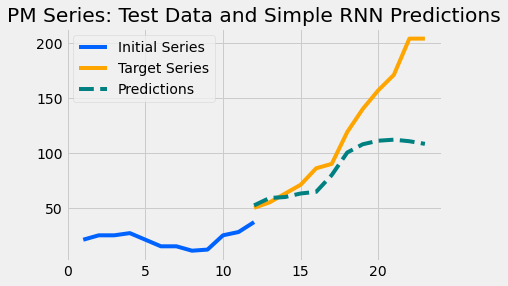

In [29]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=600)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

We can definitely get better results than before. Note that the model has the capacity to forecast an upward trend based on the trough pattern that occured recently (the input sequence). 

Once we've created a model object, we can also get information about its structure and number of parameters by using the **summary** function. This is a useful way to measure the complexity of the model and get a feel for how long it may take to train. 

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 30)                960       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________


Note that even for this relatively simple model, we already have almost a thousand parameters to train. A larger number of cell units would increase the number of parameters - this is why the training process can become so time consuming.    

#### Exercise 1: Train a simple RNN to forecast the PM_Nongzhanguan time series

We can reuse all of the functions we've defined so far in order to train models on different time series. In this exercise, you'll train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.

**Step 1**: Interpolate the missing values in the "PM_Nongzhanguan" series and plot the last 42 days of the series to get a feel for the data. 
* We'll do this step together to get started

In [31]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

date
2015-01-01 00:00:00     8.0
2015-01-01 01:00:00     7.0
2015-01-01 02:00:00     7.0
2015-01-01 03:00:00    11.0
2015-01-01 04:00:00     5.0
2015-01-01 05:00:00     3.0
2015-01-01 06:00:00     6.0
2015-01-01 07:00:00     7.0
2015-01-01 08:00:00     9.0
2015-01-01 09:00:00    11.0
Name: PM_Nongzhanguan, dtype: float64

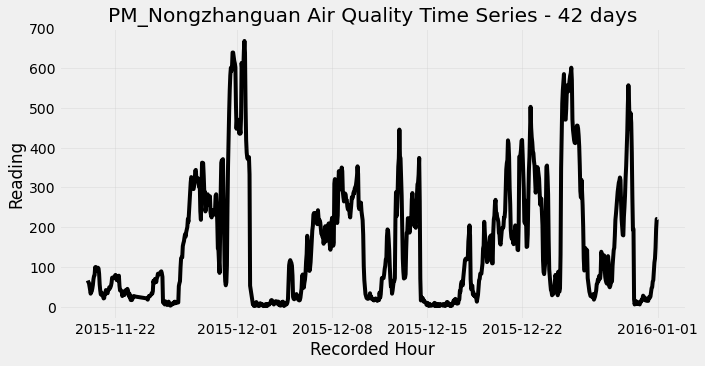

In [32]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

**Step 2**: Extract the train and test data for the "PM_Nongzhanguan" series using the function **get_train_test_data**. Use the following set of parameters:  

* **series_days** : 56
* **input_hours** : 6
* **test_hours** : 12

For reference, below is how we called the function earlier on. You can also pull up the function's documentation to review the various arguments. 

```
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days, 
                         input_hours, test_hours))
```

In [33]:
series_days = 56
input_hours = 6
test_hours = 12

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

**Step 3**: Using the extracted train data to fit a simple RNN, and use the test data to generate and plot predictions.

* Start with a simple baseline -- few cell units and epochs. From here, try to make the model more expressive by increasing units and epochs until you're satisfied with the model's predictions. 

* Be careful not to set units and/or epochs *too* high. The model may become very slow to train and also start to badly overfit the training data with the extra complexity you've added.

For reference, here's example code that you can adapt:
```
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
```

Epoch 1/1200
7/7 [==============================] - 1s 5ms/step - loss: 40580.5195
Epoch 2/1200
7/7 [==============================] - 0s 2ms/step - loss: 40366.3594
Epoch 3/1200
7/7 [==============================] - 0s 2ms/step - loss: 40242.7734
Epoch 4/1200
7/7 [==============================] - 0s 3ms/step - loss: 40067.3984
Epoch 5/1200
7/7 [==============================] - 0s 2ms/step - loss: 39928.0469
Epoch 6/1200
7/7 [==============================] - 0s 2ms/step - loss: 39708.4883
Epoch 7/1200
7/7 [==============================] - 0s 2ms/step - loss: 39634.9141
Epoch 8/1200
7/7 [==============================] - 0s 2ms/step - loss: 39572.5938
Epoch 9/1200
7/7 [==============================] - 0s 2ms/step - loss: 39512.5781
Epoch 10/1200
7/7 [==============================] - 0s 2ms/step - loss: 39451.7109
Epoch 11/1200
7/7 [==============================] - 0s 2ms/step - loss: 39391.2070
Epoch 12/1200
7/7 [==============================] - 0s 2ms/step - loss: 39327.2812
E

7/7 [==============================] - 0s 2ms/step - loss: 34276.8516
Epoch 99/1200
7/7 [==============================] - 0s 2ms/step - loss: 34226.9961
Epoch 100/1200
7/7 [==============================] - 0s 2ms/step - loss: 34176.9180
Epoch 101/1200
7/7 [==============================] - 0s 2ms/step - loss: 34126.1445
Epoch 102/1200
7/7 [==============================] - 0s 2ms/step - loss: 34075.8672
Epoch 103/1200
7/7 [==============================] - 0s 2ms/step - loss: 34027.3398
Epoch 104/1200
7/7 [==============================] - 0s 2ms/step - loss: 33976.2422
Epoch 105/1200
7/7 [==============================] - 0s 3ms/step - loss: 33927.6992
Epoch 106/1200
7/7 [==============================] - 0s 2ms/step - loss: 33877.3203
Epoch 107/1200
7/7 [==============================] - 0s 2ms/step - loss: 33827.7617
Epoch 108/1200
7/7 [==============================] - 0s 2ms/step - loss: 33777.8516
Epoch 109/1200
7/7 [==============================] - 0s 2ms/step - loss: 33727.3

7/7 [==============================] - 0s 2ms/step - loss: 29825.3379
Epoch 195/1200
7/7 [==============================] - 0s 2ms/step - loss: 29783.5332
Epoch 196/1200
7/7 [==============================] - 0s 2ms/step - loss: 29740.4590
Epoch 197/1200
7/7 [==============================] - 0s 2ms/step - loss: 29697.9141
Epoch 198/1200
7/7 [==============================] - 0s 2ms/step - loss: 29655.9863
Epoch 199/1200
7/7 [==============================] - 0s 2ms/step - loss: 29613.3535
Epoch 200/1200
7/7 [==============================] - 0s 2ms/step - loss: 29571.6133
Epoch 201/1200
7/7 [==============================] - 0s 2ms/step - loss: 29530.0430
Epoch 202/1200
7/7 [==============================] - 0s 2ms/step - loss: 29486.8145
Epoch 203/1200
7/7 [==============================] - 0s 2ms/step - loss: 29444.8730
Epoch 204/1200
7/7 [==============================] - 0s 2ms/step - loss: 29402.6680
Epoch 205/1200
7/7 [==============================] - 0s 2ms/step - loss: 29360.

7/7 [==============================] - 0s 2ms/step - loss: 26022.7188
Epoch 291/1200
7/7 [==============================] - 0s 2ms/step - loss: 25986.8027
Epoch 292/1200
7/7 [==============================] - 0s 2ms/step - loss: 25949.7578
Epoch 293/1200
7/7 [==============================] - 0s 2ms/step - loss: 25913.0293
Epoch 294/1200
7/7 [==============================] - 0s 2ms/step - loss: 25876.1465
Epoch 295/1200
7/7 [==============================] - 0s 2ms/step - loss: 25839.0488
Epoch 296/1200
7/7 [==============================] - 0s 2ms/step - loss: 25802.8809
Epoch 297/1200
7/7 [==============================] - 0s 2ms/step - loss: 25766.8203
Epoch 298/1200
7/7 [==============================] - 0s 2ms/step - loss: 25729.9238
Epoch 299/1200
7/7 [==============================] - 0s 2ms/step - loss: 25694.9609
Epoch 300/1200
7/7 [==============================] - 0s 2ms/step - loss: 25657.2715
Epoch 301/1200
7/7 [==============================] - 0s 2ms/step - loss: 25621.

7/7 [==============================] - 0s 2ms/step - loss: 22725.3730
Epoch 387/1200
7/7 [==============================] - 0s 2ms/step - loss: 22693.7832
Epoch 388/1200
7/7 [==============================] - 0s 2ms/step - loss: 22660.1523
Epoch 389/1200
7/7 [==============================] - 0s 2ms/step - loss: 22628.2773
Epoch 390/1200
7/7 [==============================] - 0s 2ms/step - loss: 22597.0742
Epoch 391/1200
7/7 [==============================] - 0s 2ms/step - loss: 22563.6055
Epoch 392/1200
7/7 [==============================] - 0s 2ms/step - loss: 22533.0742
Epoch 393/1200
7/7 [==============================] - 0s 2ms/step - loss: 22499.8242
Epoch 394/1200
7/7 [==============================] - 0s 2ms/step - loss: 22468.4121
Epoch 395/1200
7/7 [==============================] - 0s 2ms/step - loss: 22437.5684
Epoch 396/1200
7/7 [==============================] - 0s 2ms/step - loss: 22405.2246
Epoch 397/1200
7/7 [==============================] - 0s 2ms/step - loss: 22373.

7/7 [==============================] - 0s 2ms/step - loss: 19833.3555
Epoch 483/1200
7/7 [==============================] - 0s 2ms/step - loss: 19805.9023
Epoch 484/1200
7/7 [==============================] - ETA: 0s - loss: 22703.763 - 0s 2ms/step - loss: 19776.4316
Epoch 485/1200
7/7 [==============================] - 0s 2ms/step - loss: 19748.0430
Epoch 486/1200
7/7 [==============================] - 0s 2ms/step - loss: 19721.9824
Epoch 487/1200
7/7 [==============================] - 0s 2ms/step - loss: 19692.8379
Epoch 488/1200
7/7 [==============================] - 0s 2ms/step - loss: 19664.5020
Epoch 489/1200
7/7 [==============================] - 0s 2ms/step - loss: 19636.8613
Epoch 490/1200
7/7 [==============================] - 0s 2ms/step - loss: 19608.6426
Epoch 491/1200
7/7 [==============================] - 0s 2ms/step - loss: 19581.1309
Epoch 492/1200
7/7 [==============================] - 0s 2ms/step - loss: 19553.1055
Epoch 493/1200
7/7 [==============================] 

7/7 [==============================] - 0s 2ms/step - loss: 17296.0488
Epoch 578/1200
7/7 [==============================] - 0s 2ms/step - loss: 17269.9238
Epoch 579/1200
7/7 [==============================] - 0s 3ms/step - loss: 17242.4805
Epoch 580/1200
7/7 [==============================] - 0s 3ms/step - loss: 17216.0371
Epoch 581/1200
7/7 [==============================] - 0s 2ms/step - loss: 17191.3066
Epoch 582/1200
7/7 [==============================] - 0s 2ms/step - loss: 17165.9746
Epoch 583/1200
7/7 [==============================] - 0s 2ms/step - loss: 17140.1426
Epoch 584/1200
7/7 [==============================] - 0s 2ms/step - loss: 17116.0957
Epoch 585/1200
7/7 [==============================] - 0s 2ms/step - loss: 17089.2891
Epoch 586/1200
7/7 [==============================] - 0s 2ms/step - loss: 17066.1934
Epoch 587/1200
7/7 [==============================] - 0s 2ms/step - loss: 17040.0527
Epoch 588/1200
7/7 [==============================] - 0s 2ms/step - loss: 17014.

7/7 [==============================] - 0s 2ms/step - loss: 15027.4521
Epoch 674/1200
7/7 [==============================] - 0s 2ms/step - loss: 15004.4805
Epoch 675/1200
7/7 [==============================] - 0s 2ms/step - loss: 14984.7988
Epoch 676/1200
7/7 [==============================] - 0s 2ms/step - loss: 14964.5654
Epoch 677/1200
7/7 [==============================] - 0s 2ms/step - loss: 14940.4912
Epoch 678/1200
7/7 [==============================] - 0s 2ms/step - loss: 14921.3623
Epoch 679/1200
7/7 [==============================] - 0s 2ms/step - loss: 14898.2041
Epoch 680/1200
7/7 [==============================] - 0s 2ms/step - loss: 14877.6855
Epoch 681/1200
7/7 [==============================] - 0s 2ms/step - loss: 14855.9443
Epoch 682/1200
7/7 [==============================] - 0s 2ms/step - loss: 14832.1240
Epoch 683/1200
7/7 [==============================] - 0s 2ms/step - loss: 14810.4346
Epoch 684/1200
7/7 [==============================] - 0s 2ms/step - loss: 14789.

7/7 [==============================] - 0s 2ms/step - loss: 13049.6602
Epoch 770/1200
7/7 [==============================] - 0s 2ms/step - loss: 13028.3125
Epoch 771/1200
7/7 [==============================] - 0s 2ms/step - loss: 13009.8311
Epoch 772/1200
7/7 [==============================] - 0s 2ms/step - loss: 12992.0859
Epoch 773/1200
7/7 [==============================] - 0s 2ms/step - loss: 12971.9990
Epoch 774/1200
7/7 [==============================] - 0s 2ms/step - loss: 12953.3096
Epoch 775/1200
7/7 [==============================] - 0s 2ms/step - loss: 12931.9434
Epoch 776/1200
7/7 [==============================] - 0s 2ms/step - loss: 12917.3848
Epoch 777/1200
7/7 [==============================] - 0s 2ms/step - loss: 12899.6660
Epoch 778/1200
7/7 [==============================] - 0s 2ms/step - loss: 12877.4561
Epoch 779/1200
7/7 [==============================] - 0s 2ms/step - loss: 12860.2256
Epoch 780/1200
7/7 [==============================] - 0s 2ms/step - loss: 12838.

7/7 [==============================] - 0s 2ms/step - loss: 11329.9932
Epoch 866/1200
7/7 [==============================] - 0s 2ms/step - loss: 11313.8633
Epoch 867/1200
7/7 [==============================] - 0s 2ms/step - loss: 11297.1699
Epoch 868/1200
7/7 [==============================] - 0s 2ms/step - loss: 11279.3457
Epoch 869/1200
7/7 [==============================] - 0s 2ms/step - loss: 11262.9629
Epoch 870/1200
7/7 [==============================] - 0s 2ms/step - loss: 11248.2783
Epoch 871/1200
7/7 [==============================] - 0s 2ms/step - loss: 11231.1602
Epoch 872/1200
7/7 [==============================] - 0s 2ms/step - loss: 11213.1602
Epoch 873/1200
7/7 [==============================] - 0s 2ms/step - loss: 11198.0713
Epoch 874/1200
7/7 [==============================] - 0s 2ms/step - loss: 11180.6367
Epoch 875/1200
7/7 [==============================] - 0s 2ms/step - loss: 11163.6152
Epoch 876/1200
7/7 [==============================] - 0s 2ms/step - loss: 11148.

7/7 [==============================] - 0s 2ms/step - loss: 9837.9385
Epoch 962/1200
7/7 [==============================] - 0s 2ms/step - loss: 9824.2373
Epoch 963/1200
7/7 [==============================] - 0s 2ms/step - loss: 9811.3799
Epoch 964/1200
7/7 [==============================] - 0s 2ms/step - loss: 9795.9082
Epoch 965/1200
7/7 [==============================] - 0s 2ms/step - loss: 9781.2695
Epoch 966/1200
7/7 [==============================] - 0s 2ms/step - loss: 9765.7334
Epoch 967/1200
7/7 [==============================] - 0s 2ms/step - loss: 9753.8135
Epoch 968/1200
7/7 [==============================] - 0s 2ms/step - loss: 9738.9971
Epoch 969/1200
7/7 [==============================] - 0s 2ms/step - loss: 9723.2686
Epoch 970/1200
7/7 [==============================] - 0s 2ms/step - loss: 9709.8525
Epoch 971/1200
7/7 [==============================] - 0s 2ms/step - loss: 9696.7920
Epoch 972/1200
7/7 [==============================] - 0s 2ms/step - loss: 9681.1572
Epoch 9

7/7 [==============================] - 0s 2ms/step - loss: 8528.4648
Epoch 1059/1200
7/7 [==============================] - 0s 2ms/step - loss: 8518.5195
Epoch 1060/1200
7/7 [==============================] - 0s 2ms/step - loss: 8508.1992
Epoch 1061/1200
7/7 [==============================] - 0s 2ms/step - loss: 8498.3926
Epoch 1062/1200
7/7 [==============================] - 0s 2ms/step - loss: 8484.1436
Epoch 1063/1200
7/7 [==============================] - 0s 2ms/step - loss: 8467.6123
Epoch 1064/1200
7/7 [==============================] - 0s 2ms/step - loss: 8453.5059
Epoch 1065/1200
7/7 [==============================] - 0s 2ms/step - loss: 8441.1514
Epoch 1066/1200
7/7 [==============================] - 0s 2ms/step - loss: 8428.4775
Epoch 1067/1200
7/7 [==============================] - 0s 2ms/step - loss: 8417.3008
Epoch 1068/1200
7/7 [==============================] - 0s 2ms/step - loss: 8404.4873
Epoch 1069/1200
7/7 [==============================] - 0s 2ms/step - loss: 8389.2

7/7 [==============================] - 0s 2ms/step - loss: 7407.5488
Epoch 1155/1200
7/7 [==============================] - 0s 2ms/step - loss: 7397.0029
Epoch 1156/1200
7/7 [==============================] - 0s 2ms/step - loss: 7385.7744
Epoch 1157/1200
7/7 [==============================] - 0s 2ms/step - loss: 7377.3101
Epoch 1158/1200
7/7 [==============================] - 0s 2ms/step - loss: 7364.0010
Epoch 1159/1200
7/7 [==============================] - 0s 2ms/step - loss: 7355.2812
Epoch 1160/1200
7/7 [==============================] - 0s 2ms/step - loss: 7344.7393
Epoch 1161/1200
7/7 [==============================] - 0s 2ms/step - loss: 7333.2456
Epoch 1162/1200
7/7 [==============================] - 0s 2ms/step - loss: 7321.0635
Epoch 1163/1200
7/7 [==============================] - 0s 2ms/step - loss: 7312.7964
Epoch 1164/1200
7/7 [==============================] - 0s 2ms/step - loss: 7302.2417
Epoch 1165/1200
7/7 [==============================] - 0s 2ms/step - loss: 7294.2

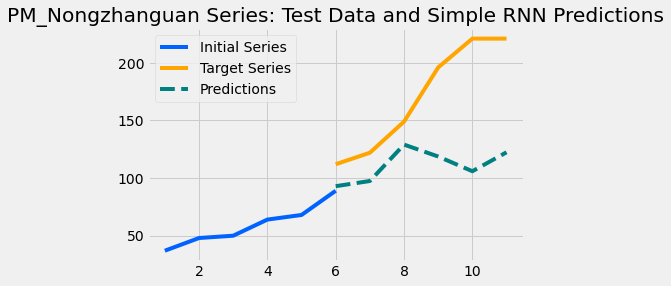

In [34]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and Simple RNN Predictions')

Again, we're able to do a decent job forecasting the continuation of an uptrend. We'll likely face more difficulty if we try to predict further into the future, especially with a simple RNN. 

# Section 2: LSTM

In this section, we'll build on our previous work by introducing LSTM models as an enhancement to the RNNs we've trained so far. Our first step will be to write a new function for fitting an LSTM with keras - notice that it's almost the same as our simple RNN function, with **LSTM** substitued for **SimpleRNN** (this is a nice display of how flexible keras is). 

Take some time to review the logic of the function while we go ahead and run the example cell below (it will take a while). 

In [37]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y 
    
    arguments
    ---------
    train_X (array): input sequence samples for training 
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells  
    epochs (int): number of training epochs   
    """
    
    # initialize model
    model = Sequential() 
    
    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format 
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1))) #,return_sequences= True))
    #model.add(LSTM(cell_units_l2, input_shape=(train_X.shape[1],1)))
    
    # add an output layer to make final predictions 
    model.add(Dense(1))
    
    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=1)
    
    return model

#### Example 2: Train a LSTM to forecast the PM_Nongzhanguan time series

With our new LSTM training function and all of our previously defined utility functions, adapting our code for LSTM forecasting will be fairly simple. We can extract the data as we did before, call the **fit_LSTM** function to build a model, and run the same *predict_and_plot* code.

Remember that one of the key benefits of LSTMs over simple RNNs is that they are better equipped to handle long input sequences and long-term dependencies. To see this evidence of this, we'll set *input_hours* to 12 and *test_hours* to 96 and see how our model predictions turn out with LSTM.  

Epoch 1/3000
6/6 [==============================] - 1s 9ms/step - loss: 44113.0664
Epoch 2/3000
6/6 [==============================] - 0s 9ms/step - loss: 44020.3594
Epoch 3/3000
6/6 [==============================] - 0s 9ms/step - loss: 43941.4844
Epoch 4/3000
6/6 [==============================] - 0s 9ms/step - loss: 43837.1719
Epoch 5/3000
6/6 [==============================] - 0s 9ms/step - loss: 43684.6055
Epoch 6/3000
6/6 [==============================] - 0s 9ms/step - loss: 43507.5703
Epoch 7/3000
6/6 [==============================] - 0s 8ms/step - loss: 43364.1289
Epoch 8/3000
6/6 [==============================] - 0s 8ms/step - loss: 43226.3750
Epoch 9/3000
6/6 [==============================] - 0s 8ms/step - loss: 43035.3555
Epoch 10/3000
6/6 [==============================] - 0s 8ms/step - loss: 42818.5586
Epoch 11/3000
6/6 [==============================] - 0s 8ms/step - loss: 42547.7852
Epoch 12/3000
6/6 [==============================] - 0s 9ms/step - loss: 42243.3398
E

6/6 [==============================] - 0s 9ms/step - loss: 32019.5547
Epoch 99/3000
6/6 [==============================] - 0s 9ms/step - loss: 31938.2891
Epoch 100/3000
6/6 [==============================] - 0s 8ms/step - loss: 31857.3574
Epoch 101/3000
6/6 [==============================] - 0s 8ms/step - loss: 31774.2910
Epoch 102/3000
6/6 [==============================] - 0s 9ms/step - loss: 31695.6211
Epoch 103/3000
6/6 [==============================] - 0s 9ms/step - loss: 31616.4062
Epoch 104/3000
6/6 [==============================] - 0s 9ms/step - loss: 31535.2656
Epoch 105/3000
6/6 [==============================] - 0s 9ms/step - loss: 31454.3457
Epoch 106/3000
6/6 [==============================] - 0s 8ms/step - loss: 31374.1836
Epoch 107/3000
6/6 [==============================] - 0s 8ms/step - loss: 31296.7207
Epoch 108/3000
6/6 [==============================] - 0s 8ms/step - loss: 31217.0195
Epoch 109/3000
6/6 [==============================] - 0s 8ms/step - loss: 31139.3

6/6 [==============================] - 0s 8ms/step - loss: 24977.8672
Epoch 195/3000
6/6 [==============================] - 0s 9ms/step - loss: 24912.9062
Epoch 196/3000
6/6 [==============================] - 0s 9ms/step - loss: 24848.1367
Epoch 197/3000
6/6 [==============================] - 0s 9ms/step - loss: 24787.4258
Epoch 198/3000
6/6 [==============================] - 0s 9ms/step - loss: 24724.1406
Epoch 199/3000
6/6 [==============================] - 0s 9ms/step - loss: 24663.2148
Epoch 200/3000
6/6 [==============================] - 0s 8ms/step - loss: 24598.1895
Epoch 201/3000
6/6 [==============================] - 0s 8ms/step - loss: 24537.2617
Epoch 202/3000
6/6 [==============================] - 0s 8ms/step - loss: 24477.8242
Epoch 203/3000
6/6 [==============================] - 0s 8ms/step - loss: 24416.5859
Epoch 204/3000
6/6 [==============================] - 0s 9ms/step - loss: 24353.1172
Epoch 205/3000
6/6 [==============================] - 0s 9ms/step - loss: 24293.

6/6 [==============================] - 0s 8ms/step - loss: 19688.1777
Epoch 291/3000
6/6 [==============================] - 0s 8ms/step - loss: 19637.9668
Epoch 292/3000
6/6 [==============================] - 0s 8ms/step - loss: 19589.6406
Epoch 293/3000
6/6 [==============================] - 0s 9ms/step - loss: 19542.9590
Epoch 294/3000
6/6 [==============================] - 0s 9ms/step - loss: 19495.8008
Epoch 295/3000
6/6 [==============================] - 0s 9ms/step - loss: 19446.6074
Epoch 296/3000
6/6 [==============================] - 0s 9ms/step - loss: 19399.9473
Epoch 297/3000
6/6 [==============================] - 0s 9ms/step - loss: 19352.8184
Epoch 298/3000
6/6 [==============================] - 0s 8ms/step - loss: 19303.2598
Epoch 299/3000
6/6 [==============================] - 0s 8ms/step - loss: 19257.8516
Epoch 300/3000
6/6 [==============================] - 0s 8ms/step - loss: 19210.3418
Epoch 301/3000
6/6 [==============================] - 0s 9ms/step - loss: 19164.

6/6 [==============================] - 0s 8ms/step - loss: 15551.9668
Epoch 387/3000
6/6 [==============================] - 0s 9ms/step - loss: 15515.2051
Epoch 388/3000
6/6 [==============================] - 0s 8ms/step - loss: 15475.7900
Epoch 389/3000
6/6 [==============================] - 0s 9ms/step - loss: 15436.0137
Epoch 390/3000
6/6 [==============================] - 0s 8ms/step - loss: 15399.5508
Epoch 391/3000
6/6 [==============================] - 0s 9ms/step - loss: 15363.3066
Epoch 392/3000
6/6 [==============================] - 0s 9ms/step - loss: 15327.2275
Epoch 393/3000
6/6 [==============================] - 0s 8ms/step - loss: 15287.3506
Epoch 394/3000
6/6 [==============================] - 0s 8ms/step - loss: 15251.1748
Epoch 395/3000
6/6 [==============================] - 0s 8ms/step - loss: 15211.5479
Epoch 396/3000
6/6 [==============================] - 0s 8ms/step - loss: 15177.3525
Epoch 397/3000
6/6 [==============================] - 0s 8ms/step - loss: 15140.

6/6 [==============================] - 0s 9ms/step - loss: 12330.2871
Epoch 483/3000
6/6 [==============================] - 0s 9ms/step - loss: 12299.3877
Epoch 484/3000
6/6 [==============================] - 0s 8ms/step - loss: 12270.7568
Epoch 485/3000
6/6 [==============================] - 0s 8ms/step - loss: 12242.9092
Epoch 486/3000
6/6 [==============================] - 0s 8ms/step - loss: 12214.1631
Epoch 487/3000
6/6 [==============================] - 0s 8ms/step - loss: 12186.9893
Epoch 488/3000
6/6 [==============================] - 0s 9ms/step - loss: 12159.3672
Epoch 489/3000
6/6 [==============================] - 0s 8ms/step - loss: 12128.8750
Epoch 490/3000
6/6 [==============================] - 0s 8ms/step - loss: 12098.0273
Epoch 491/3000
6/6 [==============================] - 0s 8ms/step - loss: 12069.1699
Epoch 492/3000
6/6 [==============================] - 0s 8ms/step - loss: 12038.3232
Epoch 493/3000
6/6 [==============================] - 0s 8ms/step - loss: 12011.

6/6 [==============================] - 0s 8ms/step - loss: 9834.4395
Epoch 579/3000
6/6 [==============================] - 0s 8ms/step - loss: 9812.4775
Epoch 580/3000
6/6 [==============================] - 0s 8ms/step - loss: 9789.4131
Epoch 581/3000
6/6 [==============================] - 0s 9ms/step - loss: 9766.7920
Epoch 582/3000
6/6 [==============================] - 0s 9ms/step - loss: 9744.9980
Epoch 583/3000
6/6 [==============================] - 0s 10ms/step - loss: 9720.9756
Epoch 584/3000
6/6 [==============================] - 0s 9ms/step - loss: 9698.5225
Epoch 585/3000
6/6 [==============================] - 0s 9ms/step - loss: 9673.8145
Epoch 586/3000
6/6 [==============================] - 0s 9ms/step - loss: 9652.5156
Epoch 587/3000
6/6 [==============================] - 0s 9ms/step - loss: 9630.8887
Epoch 588/3000
6/6 [==============================] - 0s 10ms/step - loss: 9606.7930
Epoch 589/3000
6/6 [==============================] - 0s 9ms/step - loss: 9587.3271
Epoch

6/6 [==============================] - 0s 8ms/step - loss: 7907.9136
Epoch 676/3000
6/6 [==============================] - 0s 8ms/step - loss: 7890.0391
Epoch 677/3000
6/6 [==============================] - 0s 8ms/step - loss: 7878.7520
Epoch 678/3000
6/6 [==============================] - 0s 8ms/step - loss: 7864.5576
Epoch 679/3000
6/6 [==============================] - 0s 8ms/step - loss: 7856.8140
Epoch 680/3000
6/6 [==============================] - 0s 8ms/step - loss: 7838.9912
Epoch 681/3000
6/6 [==============================] - 0s 8ms/step - loss: 7817.3584
Epoch 682/3000
6/6 [==============================] - 0s 8ms/step - loss: 7800.7666
Epoch 683/3000
6/6 [==============================] - 0s 8ms/step - loss: 7778.8516
Epoch 684/3000
6/6 [==============================] - 0s 8ms/step - loss: 7763.1533
Epoch 685/3000
6/6 [==============================] - 0s 8ms/step - loss: 7745.7803
Epoch 686/3000
6/6 [==============================] - 0s 8ms/step - loss: 7720.4150
Epoch 6

6/6 [==============================] - 0s 8ms/step - loss: 6430.6333
Epoch 773/3000
6/6 [==============================] - 0s 8ms/step - loss: 6421.9692
Epoch 774/3000
6/6 [==============================] - 0s 8ms/step - loss: 6404.9712
Epoch 775/3000
6/6 [==============================] - 0s 8ms/step - loss: 6388.5288
Epoch 776/3000
6/6 [==============================] - 0s 8ms/step - loss: 6382.0908
Epoch 777/3000
6/6 [==============================] - 0s 8ms/step - loss: 6370.1997
Epoch 778/3000
6/6 [==============================] - 0s 8ms/step - loss: 6355.3394
Epoch 779/3000
6/6 [==============================] - 0s 8ms/step - loss: 6339.9644
Epoch 780/3000
6/6 [==============================] - 0s 8ms/step - loss: 6326.9946
Epoch 781/3000
6/6 [==============================] - 0s 8ms/step - loss: 6315.9971
Epoch 782/3000
6/6 [==============================] - 0s 8ms/step - loss: 6298.0117
Epoch 783/3000
6/6 [==============================] - 0s 8ms/step - loss: 6285.8652
Epoch 7

6/6 [==============================] - 0s 11ms/step - loss: 5305.7056
Epoch 870/3000
6/6 [==============================] - 0s 9ms/step - loss: 5295.8350
Epoch 871/3000
6/6 [==============================] - 0s 8ms/step - loss: 5283.3638
Epoch 872/3000
6/6 [==============================] - 0s 8ms/step - loss: 5272.7974
Epoch 873/3000
6/6 [==============================] - 0s 8ms/step - loss: 5265.0073
Epoch 874/3000
6/6 [==============================] - 0s 8ms/step - loss: 5243.5825
Epoch 875/3000
6/6 [==============================] - 0s 8ms/step - loss: 5230.7109
Epoch 876/3000
6/6 [==============================] - 0s 8ms/step - loss: 5226.9639
Epoch 877/3000
6/6 [==============================] - 0s 8ms/step - loss: 5208.8027
Epoch 878/3000
6/6 [==============================] - 0s 9ms/step - loss: 5193.4668
Epoch 879/3000
6/6 [==============================] - 0s 9ms/step - loss: 5187.8232
Epoch 880/3000
6/6 [==============================] - 0s 8ms/step - loss: 5173.5732
Epoch 

6/6 [==============================] - 0s 8ms/step - loss: 4367.3379
Epoch 967/3000
6/6 [==============================] - 0s 8ms/step - loss: 4356.4395
Epoch 968/3000
6/6 [==============================] - 0s 8ms/step - loss: 4362.2402
Epoch 969/3000
6/6 [==============================] - 0s 8ms/step - loss: 4339.8350
Epoch 970/3000
6/6 [==============================] - 0s 9ms/step - loss: 4349.0918
Epoch 971/3000
6/6 [==============================] - 0s 9ms/step - loss: 4319.5903
Epoch 972/3000
6/6 [==============================] - 0s 8ms/step - loss: 4312.0239
Epoch 973/3000
6/6 [==============================] - 0s 8ms/step - loss: 4295.0317
Epoch 974/3000
6/6 [==============================] - 0s 8ms/step - loss: 4282.9790
Epoch 975/3000
6/6 [==============================] - 0s 8ms/step - loss: 4270.7207
Epoch 976/3000
6/6 [==============================] - 0s 8ms/step - loss: 4257.0537
Epoch 977/3000
6/6 [==============================] - 0s 8ms/step - loss: 4247.3677
Epoch 9

Epoch 1063/3000
6/6 [==============================] - 0s 8ms/step - loss: 3536.9214
Epoch 1064/3000
6/6 [==============================] - 0s 8ms/step - loss: 3530.1501
Epoch 1065/3000
6/6 [==============================] - 0s 8ms/step - loss: 3520.2686
Epoch 1066/3000
6/6 [==============================] - 0s 8ms/step - loss: 3514.2556
Epoch 1067/3000
6/6 [==============================] - 0s 8ms/step - loss: 3505.9595
Epoch 1068/3000
6/6 [==============================] - 0s 8ms/step - loss: 3499.0261
Epoch 1069/3000
6/6 [==============================] - 0s 8ms/step - loss: 3491.2595
Epoch 1070/3000
6/6 [==============================] - 0s 8ms/step - loss: 3487.7844
Epoch 1071/3000
6/6 [==============================] - 0s 8ms/step - loss: 3486.3254
Epoch 1072/3000
6/6 [==============================] - 0s 8ms/step - loss: 3480.2705
Epoch 1073/3000
6/6 [==============================] - 0s 8ms/step - loss: 3467.4739
Epoch 1074/3000
6/6 [==============================] - 0s 8ms/ste

6/6 [==============================] - 0s 8ms/step - loss: 2900.8640
Epoch 1160/3000
6/6 [==============================] - 0s 9ms/step - loss: 2879.0293
Epoch 1161/3000
6/6 [==============================] - 0s 8ms/step - loss: 2878.4363
Epoch 1162/3000
6/6 [==============================] - 0s 8ms/step - loss: 2884.4951
Epoch 1163/3000
6/6 [==============================] - 0s 8ms/step - loss: 2876.3296
Epoch 1164/3000
6/6 [==============================] - 0s 8ms/step - loss: 2865.8584
Epoch 1165/3000
6/6 [==============================] - 0s 8ms/step - loss: 2851.0715
Epoch 1166/3000
6/6 [==============================] - 0s 8ms/step - loss: 2845.5547
Epoch 1167/3000
6/6 [==============================] - 0s 8ms/step - loss: 2840.6594
Epoch 1168/3000
6/6 [==============================] - 0s 8ms/step - loss: 2852.8047
Epoch 1169/3000
6/6 [==============================] - 0s 8ms/step - loss: 2837.0552
Epoch 1170/3000
6/6 [==============================] - 0s 8ms/step - loss: 2826.2

6/6 [==============================] - 0s 9ms/step - loss: 2340.9490
Epoch 1256/3000
6/6 [==============================] - 0s 10ms/step - loss: 2338.1306
Epoch 1257/3000
6/6 [==============================] - 0s 9ms/step - loss: 2327.9578
Epoch 1258/3000
6/6 [==============================] - 0s 8ms/step - loss: 2322.4863
Epoch 1259/3000
6/6 [==============================] - 0s 8ms/step - loss: 2318.4011
Epoch 1260/3000
6/6 [==============================] - 0s 8ms/step - loss: 2313.4517
Epoch 1261/3000
6/6 [==============================] - 0s 8ms/step - loss: 2308.0940
Epoch 1262/3000
6/6 [==============================] - 0s 8ms/step - loss: 2303.9790
Epoch 1263/3000
6/6 [==============================] - 0s 8ms/step - loss: 2300.7244
Epoch 1264/3000
6/6 [==============================] - 0s 8ms/step - loss: 2289.4546
Epoch 1265/3000
6/6 [==============================] - 0s 8ms/step - loss: 2285.6086
Epoch 1266/3000
6/6 [==============================] - 0s 8ms/step - loss: 2280.

6/6 [==============================] - 0s 9ms/step - loss: 1907.8506
Epoch 1352/3000
6/6 [==============================] - 0s 9ms/step - loss: 1902.7209
Epoch 1353/3000
6/6 [==============================] - 0s 10ms/step - loss: 1895.0515
Epoch 1354/3000
6/6 [==============================] - 0s 9ms/step - loss: 1885.9993
Epoch 1355/3000
6/6 [==============================] - 0s 9ms/step - loss: 1880.4249
Epoch 1356/3000
6/6 [==============================] - 0s 9ms/step - loss: 1873.6030
Epoch 1357/3000
6/6 [==============================] - 0s 9ms/step - loss: 1868.4279
Epoch 1358/3000
6/6 [==============================] - 0s 10ms/step - loss: 1862.8146
Epoch 1359/3000
6/6 [==============================] - 0s 9ms/step - loss: 1859.8657
Epoch 1360/3000
6/6 [==============================] - 0s 9ms/step - loss: 1860.0305
Epoch 1361/3000
6/6 [==============================] - 0s 9ms/step - loss: 1848.9958
Epoch 1362/3000
6/6 [==============================] - 0s 9ms/step - loss: 1847

6/6 [==============================] - 0s 8ms/step - loss: 1532.6487
Epoch 1448/3000
6/6 [==============================] - 0s 9ms/step - loss: 1522.2877
Epoch 1449/3000
6/6 [==============================] - 0s 8ms/step - loss: 1517.2584
Epoch 1450/3000
6/6 [==============================] - 0s 9ms/step - loss: 1512.2267
Epoch 1451/3000
6/6 [==============================] - 0s 8ms/step - loss: 1506.7267
Epoch 1452/3000
6/6 [==============================] - 0s 8ms/step - loss: 1499.7944
Epoch 1453/3000
6/6 [==============================] - 0s 8ms/step - loss: 1495.7909
Epoch 1454/3000
6/6 [==============================] - 0s 8ms/step - loss: 1491.6473
Epoch 1455/3000
6/6 [==============================] - 0s 8ms/step - loss: 1490.6639
Epoch 1456/3000
6/6 [==============================] - 0s 8ms/step - loss: 1484.4409
Epoch 1457/3000
6/6 [==============================] - 0s 9ms/step - loss: 1482.6937
Epoch 1458/3000
6/6 [==============================] - 0s 9ms/step - loss: 1479.5

6/6 [==============================] - 0s 10ms/step - loss: 1188.5956
Epoch 1544/3000
6/6 [==============================] - 0s 10ms/step - loss: 1184.6935
Epoch 1545/3000
6/6 [==============================] - 0s 9ms/step - loss: 1183.3759
Epoch 1546/3000
6/6 [==============================] - 0s 9ms/step - loss: 1177.2786
Epoch 1547/3000
6/6 [==============================] - 0s 9ms/step - loss: 1174.5406
Epoch 1548/3000
6/6 [==============================] - 0s 9ms/step - loss: 1173.3483
Epoch 1549/3000
6/6 [==============================] - 0s 9ms/step - loss: 1167.9446
Epoch 1550/3000
6/6 [==============================] - 0s 9ms/step - loss: 1166.1859
Epoch 1551/3000
6/6 [==============================] - 0s 10ms/step - loss: 1162.0031
Epoch 1552/3000
6/6 [==============================] - 0s 9ms/step - loss: 1161.1229
Epoch 1553/3000
6/6 [==============================] - 0s 9ms/step - loss: 1157.6715
Epoch 1554/3000
6/6 [==============================] - 0s 9ms/step - loss: 115

6/6 [==============================] - 0s 8ms/step - loss: 950.7933
Epoch 1640/3000
6/6 [==============================] - 0s 8ms/step - loss: 942.8853
Epoch 1641/3000
6/6 [==============================] - 0s 8ms/step - loss: 940.8840
Epoch 1642/3000
6/6 [==============================] - 0s 8ms/step - loss: 934.5731
Epoch 1643/3000
6/6 [==============================] - 0s 8ms/step - loss: 931.9717
Epoch 1644/3000
6/6 [==============================] - 0s 8ms/step - loss: 926.9012
Epoch 1645/3000
6/6 [==============================] - 0s 8ms/step - loss: 926.6624
Epoch 1646/3000
6/6 [==============================] - 0s 9ms/step - loss: 925.6466
Epoch 1647/3000
6/6 [==============================] - 0s 8ms/step - loss: 922.6801
Epoch 1648/3000
6/6 [==============================] - 0s 8ms/step - loss: 916.9897
Epoch 1649/3000
6/6 [==============================] - 0s 8ms/step - loss: 914.0205
Epoch 1650/3000
6/6 [==============================] - 0s 8ms/step - loss: 912.0859
Epoch 16

6/6 [==============================] - 0s 9ms/step - loss: 738.1542
Epoch 1737/3000
6/6 [==============================] - 0s 8ms/step - loss: 727.6430
Epoch 1738/3000
6/6 [==============================] - 0s 8ms/step - loss: 725.4354
Epoch 1739/3000
6/6 [==============================] - 0s 8ms/step - loss: 722.2592
Epoch 1740/3000
6/6 [==============================] - 0s 9ms/step - loss: 729.1440
Epoch 1741/3000
6/6 [==============================] - 0s 9ms/step - loss: 742.5023
Epoch 1742/3000
6/6 [==============================] - 0s 9ms/step - loss: 775.6514
Epoch 1743/3000
6/6 [==============================] - 0s 9ms/step - loss: 776.4289
Epoch 1744/3000
6/6 [==============================] - 0s 9ms/step - loss: 755.2880
Epoch 1745/3000
6/6 [==============================] - 0s 9ms/step - loss: 741.4464
Epoch 1746/3000
6/6 [==============================] - 0s 9ms/step - loss: 741.6304
Epoch 1747/3000
6/6 [==============================] - 0s 9ms/step - loss: 749.4630
Epoch 17

6/6 [==============================] - 0s 9ms/step - loss: 558.0869
Epoch 1834/3000
6/6 [==============================] - 0s 10ms/step - loss: 559.3185
Epoch 1835/3000
6/6 [==============================] - 0s 8ms/step - loss: 556.9725
Epoch 1836/3000
6/6 [==============================] - 0s 8ms/step - loss: 556.2097
Epoch 1837/3000
6/6 [==============================] - 0s 8ms/step - loss: 555.3927
Epoch 1838/3000
6/6 [==============================] - 0s 8ms/step - loss: 553.1987
Epoch 1839/3000
6/6 [==============================] - 0s 8ms/step - loss: 549.0967
Epoch 1840/3000
6/6 [==============================] - 0s 8ms/step - loss: 550.0859
Epoch 1841/3000
6/6 [==============================] - 0s 8ms/step - loss: 549.3630
Epoch 1842/3000
6/6 [==============================] - 0s 8ms/step - loss: 546.2865
Epoch 1843/3000
6/6 [==============================] - 0s 8ms/step - loss: 545.9717
Epoch 1844/3000
6/6 [==============================] - 0s 8ms/step - loss: 543.2378
Epoch 1

6/6 [==============================] - 0s 8ms/step - loss: 439.6227
Epoch 1931/3000
6/6 [==============================] - 0s 8ms/step - loss: 445.5409
Epoch 1932/3000
6/6 [==============================] - 0s 9ms/step - loss: 439.8576
Epoch 1933/3000
6/6 [==============================] - 0s 8ms/step - loss: 435.0476
Epoch 1934/3000
6/6 [==============================] - 0s 9ms/step - loss: 436.4422
Epoch 1935/3000
6/6 [==============================] - 0s 9ms/step - loss: 441.3599
Epoch 1936/3000
6/6 [==============================] - 0s 10ms/step - loss: 433.1194
Epoch 1937/3000
6/6 [==============================] - 0s 10ms/step - loss: 430.1664
Epoch 1938/3000
6/6 [==============================] - 0s 9ms/step - loss: 430.1580
Epoch 1939/3000
6/6 [==============================] - 0s 9ms/step - loss: 431.5418
Epoch 1940/3000
6/6 [==============================] - 0s 9ms/step - loss: 446.1865
Epoch 1941/3000
6/6 [==============================] - 0s 8ms/step - loss: 456.6353
Epoch 

6/6 [==============================] - 0s 10ms/step - loss: 334.5696
Epoch 2028/3000
6/6 [==============================] - 0s 9ms/step - loss: 332.7402
Epoch 2029/3000
6/6 [==============================] - 0s 9ms/step - loss: 332.5526
Epoch 2030/3000
6/6 [==============================] - 0s 8ms/step - loss: 330.5389
Epoch 2031/3000
6/6 [==============================] - 0s 8ms/step - loss: 329.9173
Epoch 2032/3000
6/6 [==============================] - 0s 9ms/step - loss: 331.7450
Epoch 2033/3000
6/6 [==============================] - 0s 9ms/step - loss: 332.8018
Epoch 2034/3000
6/6 [==============================] - 0s 9ms/step - loss: 334.1232
Epoch 2035/3000
6/6 [==============================] - 0s 10ms/step - loss: 330.2292
Epoch 2036/3000
6/6 [==============================] - 0s 9ms/step - loss: 329.9656
Epoch 2037/3000
6/6 [==============================] - 0s 9ms/step - loss: 330.3029
Epoch 2038/3000
6/6 [==============================] - 0s 8ms/step - loss: 333.1342
Epoch 

6/6 [==============================] - 0s 9ms/step - loss: 259.6541
Epoch 2125/3000
6/6 [==============================] - 0s 9ms/step - loss: 260.0854
Epoch 2126/3000
6/6 [==============================] - 0s 8ms/step - loss: 260.0026
Epoch 2127/3000
6/6 [==============================] - 0s 8ms/step - loss: 260.8085
Epoch 2128/3000
6/6 [==============================] - 0s 8ms/step - loss: 261.8455
Epoch 2129/3000
6/6 [==============================] - 0s 8ms/step - loss: 270.1508
Epoch 2130/3000
6/6 [==============================] - 0s 8ms/step - loss: 264.7978
Epoch 2131/3000
6/6 [==============================] - 0s 8ms/step - loss: 262.3857
Epoch 2132/3000
6/6 [==============================] - 0s 8ms/step - loss: 263.6042
Epoch 2133/3000
6/6 [==============================] - 0s 8ms/step - loss: 267.2745
Epoch 2134/3000
6/6 [==============================] - 0s 8ms/step - loss: 259.9585
Epoch 2135/3000
6/6 [==============================] - 0s 8ms/step - loss: 253.8802
Epoch 21

6/6 [==============================] - 0s 8ms/step - loss: 201.8701
Epoch 2222/3000
6/6 [==============================] - 0s 8ms/step - loss: 211.7952
Epoch 2223/3000
6/6 [==============================] - 0s 8ms/step - loss: 212.3970
Epoch 2224/3000
6/6 [==============================] - 0s 8ms/step - loss: 211.7722
Epoch 2225/3000
6/6 [==============================] - 0s 8ms/step - loss: 208.9428
Epoch 2226/3000
6/6 [==============================] - 0s 8ms/step - loss: 205.6683
Epoch 2227/3000
6/6 [==============================] - 0s 8ms/step - loss: 203.5008
Epoch 2228/3000
6/6 [==============================] - 0s 8ms/step - loss: 204.9711
Epoch 2229/3000
6/6 [==============================] - 0s 8ms/step - loss: 205.1974
Epoch 2230/3000
6/6 [==============================] - 0s 8ms/step - loss: 210.7413
Epoch 2231/3000
6/6 [==============================] - 0s 8ms/step - loss: 208.6393
Epoch 2232/3000
6/6 [==============================] - 0s 8ms/step - loss: 204.5898
Epoch 22

6/6 [==============================] - 0s 9ms/step - loss: 159.6753
Epoch 2319/3000
6/6 [==============================] - 0s 9ms/step - loss: 155.9352
Epoch 2320/3000
6/6 [==============================] - 0s 8ms/step - loss: 154.4568
Epoch 2321/3000
6/6 [==============================] - 0s 8ms/step - loss: 153.0741
Epoch 2322/3000
6/6 [==============================] - 0s 8ms/step - loss: 150.6420
Epoch 2323/3000
6/6 [==============================] - 0s 8ms/step - loss: 151.9223
Epoch 2324/3000
6/6 [==============================] - 0s 8ms/step - loss: 152.5031
Epoch 2325/3000
6/6 [==============================] - 0s 9ms/step - loss: 148.4842
Epoch 2326/3000
6/6 [==============================] - 0s 9ms/step - loss: 150.0068
Epoch 2327/3000
6/6 [==============================] - 0s 8ms/step - loss: 149.7869
Epoch 2328/3000
6/6 [==============================] - 0s 8ms/step - loss: 146.9949
Epoch 2329/3000
6/6 [==============================] - 0s 8ms/step - loss: 147.7597
Epoch 23

6/6 [==============================] - 0s 8ms/step - loss: 140.1902
Epoch 2416/3000
6/6 [==============================] - 0s 8ms/step - loss: 149.5085
Epoch 2417/3000
6/6 [==============================] - 0s 9ms/step - loss: 142.6669
Epoch 2418/3000
6/6 [==============================] - 0s 8ms/step - loss: 149.3589
Epoch 2419/3000
6/6 [==============================] - 0s 8ms/step - loss: 143.0943
Epoch 2420/3000
6/6 [==============================] - 0s 8ms/step - loss: 148.7690
Epoch 2421/3000
6/6 [==============================] - 0s 8ms/step - loss: 163.6007
Epoch 2422/3000
6/6 [==============================] - 0s 8ms/step - loss: 167.2788
Epoch 2423/3000
6/6 [==============================] - 0s 9ms/step - loss: 213.2058
Epoch 2424/3000
6/6 [==============================] - 0s 9ms/step - loss: 277.8190
Epoch 2425/3000
6/6 [==============================] - 0s 8ms/step - loss: 270.1969
Epoch 2426/3000
6/6 [==============================] - 0s 8ms/step - loss: 272.1282
Epoch 24

6/6 [==============================] - 0s 9ms/step - loss: 103.9267
Epoch 2513/3000
6/6 [==============================] - 0s 9ms/step - loss: 104.6160
Epoch 2514/3000
6/6 [==============================] - 0s 8ms/step - loss: 112.7452
Epoch 2515/3000
6/6 [==============================] - 0s 8ms/step - loss: 114.7604
Epoch 2516/3000
6/6 [==============================] - 0s 8ms/step - loss: 126.8908
Epoch 2517/3000
6/6 [==============================] - 0s 8ms/step - loss: 126.5349
Epoch 2518/3000
6/6 [==============================] - 0s 8ms/step - loss: 132.7580
Epoch 2519/3000
6/6 [==============================] - 0s 8ms/step - loss: 127.6371
Epoch 2520/3000
6/6 [==============================] - 0s 8ms/step - loss: 122.9605
Epoch 2521/3000
6/6 [==============================] - 0s 8ms/step - loss: 112.0005
Epoch 2522/3000
6/6 [==============================] - 0s 8ms/step - loss: 108.8314
Epoch 2523/3000
6/6 [==============================] - 0s 8ms/step - loss: 105.2798
Epoch 25

6/6 [==============================] - 0s 8ms/step - loss: 89.1535
Epoch 2611/3000
6/6 [==============================] - 0s 8ms/step - loss: 91.0240
Epoch 2612/3000
6/6 [==============================] - 0s 8ms/step - loss: 92.4157
Epoch 2613/3000
6/6 [==============================] - 0s 8ms/step - loss: 91.3201
Epoch 2614/3000
6/6 [==============================] - 0s 8ms/step - loss: 93.0344
Epoch 2615/3000
6/6 [==============================] - 0s 8ms/step - loss: 92.8509
Epoch 2616/3000
6/6 [==============================] - 0s 8ms/step - loss: 96.9920
Epoch 2617/3000
6/6 [==============================] - 0s 8ms/step - loss: 95.2622
Epoch 2618/3000
6/6 [==============================] - 0s 8ms/step - loss: 95.1785
Epoch 2619/3000
6/6 [==============================] - 0s 9ms/step - loss: 94.1130
Epoch 2620/3000
6/6 [==============================] - 0s 8ms/step - loss: 91.9860
Epoch 2621/3000
6/6 [==============================] - 0s 8ms/step - loss: 97.6596
Epoch 2622/3000
6/6 

6/6 [==============================] - 0s 10ms/step - loss: 138.8144
Epoch 2708/3000
6/6 [==============================] - 0s 9ms/step - loss: 137.3270
Epoch 2709/3000
6/6 [==============================] - 0s 9ms/step - loss: 139.6394
Epoch 2710/3000
6/6 [==============================] - 0s 8ms/step - loss: 133.4628
Epoch 2711/3000
6/6 [==============================] - 0s 8ms/step - loss: 135.3254
Epoch 2712/3000
6/6 [==============================] - 0s 8ms/step - loss: 135.3129
Epoch 2713/3000
6/6 [==============================] - 0s 8ms/step - loss: 139.9497
Epoch 2714/3000
6/6 [==============================] - 0s 8ms/step - loss: 136.7414
Epoch 2715/3000
6/6 [==============================] - 0s 8ms/step - loss: 143.0817
Epoch 2716/3000
6/6 [==============================] - 0s 8ms/step - loss: 141.4956
Epoch 2717/3000
6/6 [==============================] - 0s 8ms/step - loss: 134.4616
Epoch 2718/3000
6/6 [==============================] - 0s 9ms/step - loss: 135.2072
Epoch 2

6/6 [==============================] - 0s 9ms/step - loss: 103.3495
Epoch 2805/3000
6/6 [==============================] - 0s 8ms/step - loss: 101.3431
Epoch 2806/3000
6/6 [==============================] - 0s 8ms/step - loss: 101.4015
Epoch 2807/3000
6/6 [==============================] - 0s 8ms/step - loss: 101.0433
Epoch 2808/3000
6/6 [==============================] - 0s 8ms/step - loss: 98.8658
Epoch 2809/3000
6/6 [==============================] - 0s 8ms/step - loss: 100.5294
Epoch 2810/3000
6/6 [==============================] - 0s 9ms/step - loss: 99.1937
Epoch 2811/3000
6/6 [==============================] - 0s 9ms/step - loss: 96.6680
Epoch 2812/3000
6/6 [==============================] - 0s 9ms/step - loss: 99.6828
Epoch 2813/3000
6/6 [==============================] - 0s 9ms/step - loss: 107.9549
Epoch 2814/3000
6/6 [==============================] - 0s 9ms/step - loss: 111.3839
Epoch 2815/3000
6/6 [==============================] - 0s 9ms/step - loss: 107.5650
Epoch 2816/3

6/6 [==============================] - 0s 9ms/step - loss: 141.6116
Epoch 2903/3000
6/6 [==============================] - 0s 9ms/step - loss: 143.1311
Epoch 2904/3000
6/6 [==============================] - 0s 9ms/step - loss: 113.8019
Epoch 2905/3000
6/6 [==============================] - 0s 8ms/step - loss: 111.1144
Epoch 2906/3000
6/6 [==============================] - 0s 8ms/step - loss: 100.1965
Epoch 2907/3000
6/6 [==============================] - 0s 9ms/step - loss: 98.7052
Epoch 2908/3000
6/6 [==============================] - 0s 8ms/step - loss: 101.0142
Epoch 2909/3000
6/6 [==============================] - 0s 8ms/step - loss: 103.0991
Epoch 2910/3000
6/6 [==============================] - 0s 8ms/step - loss: 102.2033
Epoch 2911/3000
6/6 [==============================] - 0s 8ms/step - loss: 98.0946
Epoch 2912/3000
6/6 [==============================] - 0s 8ms/step - loss: 87.8983
Epoch 2913/3000
6/6 [==============================] - 0s 8ms/step - loss: 85.8140
Epoch 2914/3

6/6 [==============================] - 0s 9ms/step - loss: 118.4263


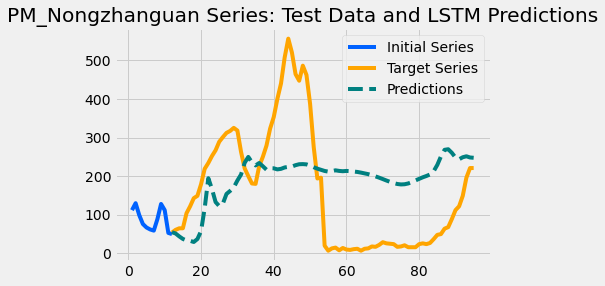

In [38]:
series_days = 50 
input_hours = 12
test_hours = 96

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days, 
                         input_hours, test_hours))

model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000) 

predict_and_plot(test_X_init, test_y, model, 
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')

In our prediction plot we can start to see how LSTMs can be more expressive than simple RNNs - instead of just extrapolating a simple trend like our previous RNN models did, this LSTM model can effectively anticipate inflection points.

You should also notice that our model starts to struggle toward the end of the predicted sequence, becoming more conservative in its predictions. To improve the quality of forecasts over many time steps, we'd likely need to use more data and more sophisticated LSTM model structures that are beyond the scope of this lesson.

Take a look at the model summary and compare it with the summary for our simple RNN from example 1. You can see that there are many more trainable parameters for the LSTM, which explains why it took a much longer time for us to train this model.

In [39]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70)                20160     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 71        
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


#### Further Exploration

The simple models we've worked with are only the tip of the iceberg for deep learning. We've been time-limited for this exercise, and typical deep learning models involve much longer training times than what we're able to do in this notebook. 

Here are several suggestions for how you could explore these ideas further, leveraging the code we've implemented today:

* Try using longer chunks of the series we've looked at in this notebook for modeling (set series_days larger than 56), or modeling other series in the dataset.
* When training with more data, try increasing cell_units and running more training epochs.  
* Try using longer input sequences with LSTM, and predicting a wider range of test hours.

# Summary

In this lesson we have covered:

1. How recurrent neural networks can be applied to sequence forecasting problems
2. How simple RNNs and LSTMs can be built and trained using the python library keras
3. The importance of tuning network parameters, and an introductory strategy for doing so


---
### Machine Learning Foundation (C) 2020 IBM Corporation